In [25]:
%cd ../..
%load_ext autoreload
%autoreload 2

/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf, report, psth_foraging
from pipeline.plot import behavior_plot, unit_characteristic_plot, unit_psth, histology_plot, PhotostimError, foraging_plot
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice, plot_unit_all_in_one

foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol=100').proj()
import datajoint as dj; dj.conn().connect()

In [56]:
    #%%
    date, imec, unit = '2021-04-18', 0, 541
    key = (ephys.Unit() & (experiment.Session & 'session_date = "2021-04-18"' & 'subject_id = 473361') & {'insertion_number': imec + 1, 'unit_uid': unit}).fetch1("KEY")

In [58]:
    import glob

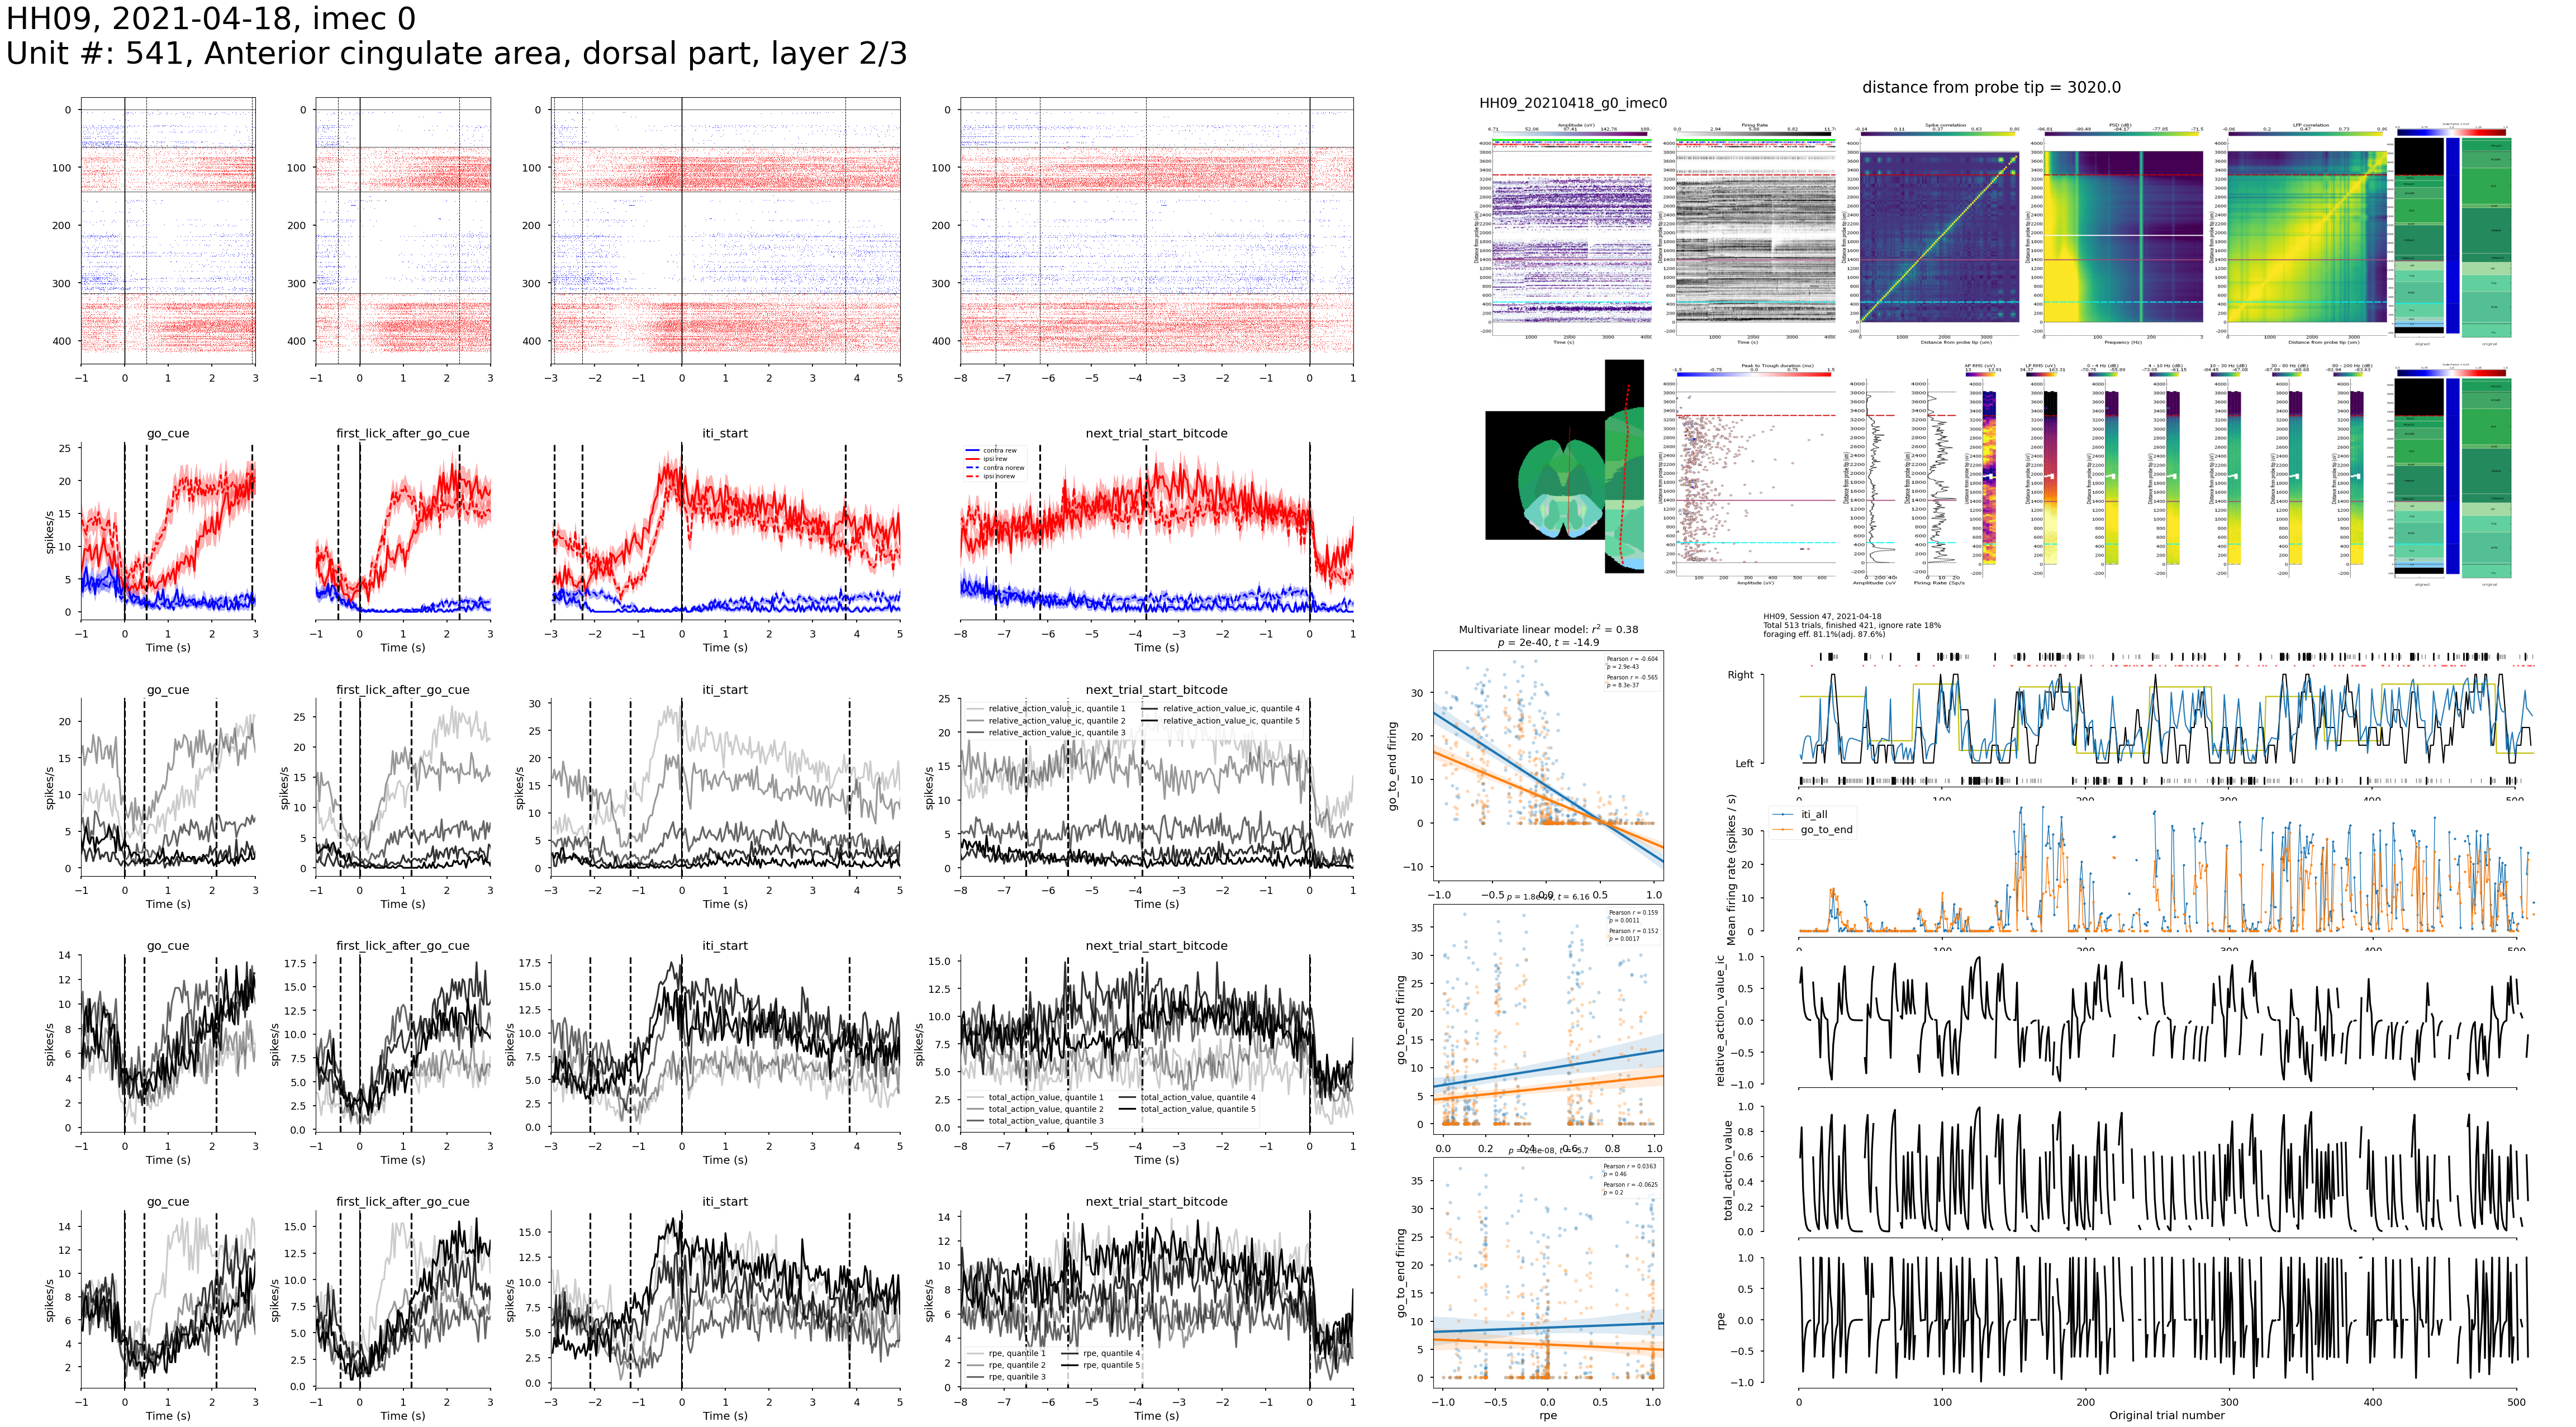

In [59]:
    #%%

    fig = plt.figure(figsize=(9*6, 5*6), dpi=100, constrained_layout=0)
    gs0 = fig.add_gridspec(2, 2, height_ratios=(1, 1.5), width_ratios=(1.1, 1), right=0.95, hspace=0.1, wspace=0.05)

    # gs_qc = gs0[0, 0].subgridspec(2, 7, hspace=0.4, wspace=0.5)
    # gs_drift = gs0[0, 1].subgridspec(2, 3, width_ratios=[6, 1, 1], height_ratios=[1, 11])
    # gs_psth = gs0[1, 0].subgridspec(10, 6, hspace=0.4)

    gs_psth = gs0[:, 0].subgridspec(5, 4, hspace=0.4, height_ratios=(1.5, 1, 1, 1, 1))
    gs_align = gs0[0, 1].subgridspec(1, 1)
    
    gs_tuning_fit = gs0[1, 1].subgridspec(1, 2, width_ratios=[1, 3], hspace=0.1, wspace=0.15)
    gs_tuning = gs_tuning_fit[0, 1].subgridspec(5, 1, hspace=0.1)
    gs_fit = gs_tuning_fit[0, 0].subgridspec(3, 1, hspace=0.1)

    #for ax in (*axs_meta, *axs_psth, *axs_tuning): fig.add_subplot(ax)        


    best_model = (foraging_model.FittedSessionModelComparison.BestModel & key
                  & 'model_comparison_idx=1').fetch1('best_aic')
    align_types = ['go_cue', 'first_lick_after_go_cue',
                   'iti_start', 'next_trial_start']
    latent_variables = ['relative_action_value_ic', 'total_action_value', 'rpe']
    
    h2o = (lab.WaterRestriction & key).fetch1("water_restriction_number")
    
    # === 1. meta info (spike QC etc.) ===
    # Add unit info
    try:
        area_annotation = (((ephys.Unit & key) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation).fetch1("annotation")
    except:
        area_annotation = 'nan'
    unit_info = (f'{h2o}, '
                f'{(experiment.Session & key).fetch1("session_date")}, '
                f'imec {key["insertion_number"]-1}\n'
                f'Unit #: {key["unit"]}, '
                f'{area_annotation}'
                )
    fig.text(0.1, 0.9, unit_info, fontsize=40)

    # -- mean waveform --
#     wave_form = (ephys.Unit & key).fetch1('waveform')
#     ts = (1 / (ephys.ProbeInsertion.RecordingSystemSetup & key).fetch1('sampling_rate') * 1000) * range(len(wave_form))

#     ax = fig.add_subplot(gs_qc[:1, 0])
#     ax.plot(ts, wave_form)
#     ax.set(xticks=[0, 1], xlabel='ms', ylabel=R'$\mu V$')
#     sns.despine(ax=ax, trim=True)
    
    # -- alignment --
    q_key_electrode = (lab.ProbeType.Electrode * lab.ElectrodeConfig.Electrode * ephys.ProbeInsertion * ephys.Unit & key)
    probe_type, insertion_num, shank, y_coord = q_key_electrode.fetch1('probe_type', 'insertion_number', 'shank', 'y_coord')
    if_MS = 'MS' in probe_type
    h2o = (lab.WaterRestriction & key).fetch1("water_restriction_number")
    date_str = (experiment.Session & key).fetch1("session_date").strftime("%Y%m%d")
    imec_str = f'imec{insertion_num - 1}'

    alignment_fs = glob.glob(r'/home/jupyter/s3-drive/alignment/' + f'{h2o}*{date_str}*{imec_str}' + (f'shank{shank}' if if_MS else '') + '*overview.png')

    if len(alignment_fs):
        im_align = plt.imread(alignment_fs[0])

        ax_align = fig.add_subplot(gs_align[:, :])
        ax_align.imshow(im_align)
        ax_align.axis('off')
        ax_align.set_title(f'distance from probe tip = {y_coord}', fontsize=20)
    

    # -- spike widths --
    # half_width_this_session = (ephys.UnitWaveformWidth & (experiment.Session & key) & 
    #                            (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat & 
    #                             'presence_ratio > 0.9' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70')
    #                            ).fetch('waveform_width')
    # ax = fig.add_subplot(gs_qc[1, 0])
    # ax.hist(half_width_this_session, 30, color='b')
    # ax.set(xlabel='Spk widths (this session, ms)')
    # ax.axvline((ephys.UnitWaveformWidth & key).fetch1('waveform_width'), color='g', linestyle='-')

    # -- unit QC --
#     axs = np.array([fig.add_subplot(gs_qc[row_idx, col_idx])
#                     for row_idx, col_idx in itertools.product(range(0, 2), range(1, 4))])

#     amp, snr, spk_rate, isi_violation, amplitude_cutoff, presence_ratio = (ephys.Unit * ephys.UnitStat * ephys.ClusterMetric & key).fetch1(
#                                         'unit_amp', 'unit_snr', 'avg_firing_rate', 'isi_violation', 'amplitude_cutoff', 'presence_ratio')

#     unit_characteristic_plot.plot_clustering_quality_foraging(ephys.ProbeInsertion & key, axs=axs,
#                                                               highlight_unit={'amp': amp, 'snr': snr,
#                                                                               'isi': np.log10(isi_violation + 1e-5),
#                                                                               'rate': np.log10(spk_rate),
#                                                                               'amplitude_cutoff': amplitude_cutoff,
#                                                                               'presence_ratio': presence_ratio},
#                                                               qc_boundary={'amp': 70, 'isi': np.log10(0.5),
#                                                                            'amplitude_cutoff': 0.1,
#                                                                            'presence_ratio': 0.95}
#                                                               )

    # -- unit QC along the probe --
    # axs = np.array([fig.add_subplot(gs_qc[:2, col_idx])
    #                 for col_idx in range(4, 7)])
    # unit_characteristic_plot.plot_unit_characteristic(ephys.ProbeInsertion & key, axs=axs, m_scale=500, highlight_unit=key)

    # -- drift map --
    # axs = [fig.add_subplot(gs_drift[row_idx, col_idx])
    #        for row_idx, col_idx in ((1, 0), (0, 0), (1, 1), (1, 2))]
    # unit_characteristic_plot.plot_driftmap(ephys.ProbeInsertion & key, axs=axs)


    # === 2. raster & psth ===
    # --- 2.1 choice & outcome ---
    unit_psth.plot_unit_psth_choice_outcome(
        unit_key=key,
        align_types=align_types,
        axs=np.array([fig.add_subplot(gs_psth[row_idx, col_idx])
                      # for row_idx, col_idx in itertools.product(range(2, 4), range(5))]).reshape(2, 5))
                      for row_idx, col_idx in itertools.product(range(0, 2), range(4))]).reshape(2, 4))

    # --- 2.2 deltaQ, sumQ, RPE ---
    # index_range = range(4, 7)
    index_range = range(2, 5)

    for idx, latent_variable in zip(index_range, latent_variables):
        axs = np.array([fig.add_subplot(gs_psth[row_idx, col_idx])
                          for row_idx, col_idx in itertools.product(range(idx, idx+1), range(4))]).reshape(1, 4)
        unit_psth.plot_unit_psth_latent_variable_quantile(
            unit_key=key,
            axs=axs,
            model_id=best_model,
            align_types=align_types,
            latent_variable=latent_variable,
            if_sem=False)
        

    # === 3. period selectivity ===
    independent_variable=['relative_action_value_ic', 'total_action_value', 'rpe']
    axs = {'choice_history': fig.add_subplot(gs_tuning[0, 0]),
           'period_firing': fig.add_subplot(gs_tuning[1, 0]),}
    
    for n, iv in enumerate(independent_variable):
        axs['time_' + iv] = fig.add_subplot(gs_tuning[n + 2, 0])
        axs['fit_' + iv] = fig.add_subplot(gs_fit[n, 0])

    unit_psth.plot_unit_period_tuning(unit_key=key,
                                      independent_variable=independent_variable,
                                      period=['iti_all', 'go_to_end'],
                                      model_id=None,  # Best model of this session
                                      axs=axs)
    axs['choice_history'].legend().set_visible(False)
    

In [39]:
(ephys.Unit * ephys.ProbeInsertion.InsertionLocation.proj('depth') * ephys.UnitStat
                  * lab.ElectrodeConfig.Electrode.proj() * lab.ProbeType.Electrode.proj('x_coord', 'y_coord')
                   & key).proj(
            ..., x='x_coord', y='y_coord')

*subject_id    *session    *insertion_number    *clustering_method    *unit    *probe_type              *electrode_config_name    *electrode_group    *electrode    unit_uid     unit_quality     unit_posx     unit_posy     spike_time spike_site spike_dept unit_amp               unit_snr              waveform   depth        isi_violation     avg_firing_rate     x        y         
+------------+ +---------+ +------------------+ +-------------------+ +------+ +----------------------+ +-----------------------+ +-----------------+ +-----------+ +----------+ +--------------+ +-----------+ +-----------+ +--------+ +--------+ +--------+ +--------------------+ +-------------------+ +--------+ +----------+ +---------------+ +-----------------+ +------+ +--------+
473361         47          1                    kilosort2             541      neuropixels 1.0 - 3B     1-384                     0                   304           541          good             43.0          3020.0        =BLOB=     =BLOB=     =BLOB=     241.63514114954225     7.473195324638051     =BLOB=     -3600.00     0.00148861        7.76451             32.0     3020.0    
 (Total: 1)

In [47]:
key

{'subject_id': 473361,
 'session': 47,
 'insertion_number': 1,
 'clustering_method': 'kilosort2',
 'unit': 541}

In [ ]:
meta = re.search(r'(.*)[\\|/](?P<h2o>[^_]*)_(?P<date>\w+)_(?P<g>g\d+)_(?P<imec>imec\d+)\\alf', alf)

In [9]:
import glob


In [61]:
q_key_electrode

*probe_type              *electrode    *electrode_config_name    *electrode_group    *subject_id    *session    *insertion_number    *clustering_method    *unit    shank     shank_col     shank_row     x_coord     y_coord     z_coord     is_used     probe           unit_uid     unit_quality     unit_posx     unit_posy     spike_time spike_site spike_dept unit_amp               unit_snr              waveform  
+----------------------+ +-----------+ +-----------------------+ +-----------------+ +------------+ +---------+ +------------------+ +-------------------+ +------+ +-------+ +-----------+ +-----------+ +---------+ +---------+ +---------+ +---------+ +-------------+ +----------+ +--------------+ +-----------+ +-----------+ +--------+ +--------+ +--------+ +--------------------+ +-------------------+ +--------+
neuropixels 1.0 - 3B     304           1-384                     0                   473361         47          1                    kilosort2             541      1         2             152           32.0        3020.0      0.0         1           18005123491     541          good             43.0          3020.0        =BLOB=     =BLOB=     =BLOB=     241.63514114954225     7.473195324638051     =BLOB=    
 (Total: 1)

In [16]:
report.UnitLevelForagingEphysReportAllInOne.progress()

UnitLevelForagingEphysReportAllInOne Completed 5835 of 6501 (89.8%)   2022-11-17 17:52:55


(666, 6501)

In [23]:
report.UnitLevelForagingEphysReportAllInOne()

*subject_id    *session    *insertion_number    *clustering_method    *unit    unit_forag
+------------+ +---------+ +------------------+ +-------------------+ +------+ +--------+

 (Total: 0)

In [40]:
region_ann_lut = {
    # premotor
    'ALM': ["Secondary motor area%"],
    
    # isocortex, PFC
    'PL': ["Prelimbic%"],
    'ACA': ["Anterior cingulate area%"],
    'ILA': ["Infralimbic%"],
    'ORB': ['%orbital%'],
    # 'FRP': '%frontal%',
    'RSP': ["Retrosplenial area%"],
    
    # thalamus
    'VM': ['Ventral medial%'],
    'MD': ['Mediodorsal%'],
    'VPM': ['Ventral posteromedial%'],
    'HY': ['Hypothalamus', 'Zona %'],
    
    # striatum
    'LSN': ["Lateral septal nucleus%"],
    'STRd': ["Caudoputamen%"],
    'STRv': ["Nucleus accumbens%", "Fundus%"],
    'striatum': ["striatum%"],
    
    # Pallidum
    'PALv': ["Substantia innominata%", "Magnocellular%"],
    
    # Olfactory
    'OLF': ["%olfactory%"],
}


for region, areas in region_ann_lut.items():
    q_string = ' OR '.join([f'annotation LIKE "{s}"' for s in areas])
    if len(ephys.Unit  * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation & key & q_string):
        region_found = region
        break
else:
    region_found = ''

region_found

'ALM'

In [32]:
key = (((ephys.Unit & foraging_sessions) * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation) & q_string).fetch('KEY', limit=1)[0]

In [44]:
region_found == ''

True

## Clean up external entries

In [55]:
s = report.schema
(s.external['report_store'] & 'timestamp > "2022-11-01"').delete(delete_external_files=False)